In [1]:
import pybullet as p
import pybullet_data
import time

# Flag debug: jika True, akan menggambar marker pada thruster dan kontak kaki

def main():
    # Hubungkan ke PyBullet dengan GUI
    physicsClient = p.connect(p.GUI)
    p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)
    
    # Atur direktori tambahan untuk file URDF dan file data PyBullet
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    
    # Set gravitasi sesuai lingkungan bulan (1.625 m/s² ke bawah)
    p.setGravity(0, 0, -9.8)
    
    # Muat plane sebagai permukaan bulan
    planeId = p.loadURDF("plane.urdf")
    
    # Muat URDF Lunar Lander (sesuaikan path dengan struktur folder Anda)
    landerStartPos = [0, 0, 3]  # Posisi awal (x, y, z)
    landerStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
    landerId = p.loadURDF("LunarLander3DEnv/envs/urdf/lunarlander.urdf", 
                          landerStartPos, landerStartOrientation, useFixedBase=False)
    
    # Debug: Cetak jumlah joint dan mapping nama link
    num_joints = p.getNumJoints(landerId)
    print("Jumlah joint dalam Lunar Lander:", num_joints)
    
    # Mapping untuk thruster dan leg
    thruster_links = {}  # Misalnya: {"thruster_1": joint_index, ...}
    leg_links = {}       # Misalnya: {"leg_1": joint_index, ...}
    for i in range(num_joints):
        joint_info = p.getJointInfo(landerId, i)
        joint_name = joint_info[1].decode("utf-8")
        link_name = joint_info[12].decode("utf-8")
        #print("Joint index:", i, "Joint name:", joint_name, "Link name:", link_name)
        if link_name in ["thruster_1", "thruster_2", "thruster_3", "thruster_4"]:
            thruster_links[link_name] = i
        if link_name in ["leg_1", "leg_2", "leg_3", "leg_4"]:
            leg_links[link_name] = i

    # Nilai gaya thruster yang akan diterapkan (contoh: gaya ke atas)
    thruster_forces = {
    "thruster_1": [0, 0, 000],
    "thruster_2": [0, 0, 00],
    "thruster_3": [0, 0, 000],
    "thruster_4": [0, 0, 000],
    }

    timeStep = 1. / 240.
    while True:
        
        
        # Terapkan gaya eksternal ke setiap thruster
        for thruster_name, link_index in thruster_links.items():
            thrust_force = thruster_forces[thruster_name]
            p.applyExternalForce(objectUniqueId=landerId,
                                 linkIndex=link_index,
                                 forceObj=thrust_force,
                                 posObj=[0, 0, 0],  # Titik aplikasi (origin dari frame link)
                                 flags=p.LINK_FRAME)
            
       
       # Periksa kontak kaki (leg) dengan plane dan tampilkan informasi di terminal
        for leg_name, link_index in leg_links.items():
           contacts = p.getContactPoints(bodyA=landerId, bodyB=planeId, linkIndexA=link_index)
           if contacts:
               for contact in contacts:
                   contact_pos = contact[5]  # Posisi kontak pada leg
                   #print(f"Kontak terdeteksi pada {leg_name} di posisi {contact_pos}")
                # Ambil state (posisi, orientasi, kecepatan) dari main body
        pos, orn = p.getBasePositionAndOrientation(landerId)
        lin_vel, ang_vel = p.getBaseVelocity(landerId)
        
        # Buat string informasi aksi dan state
        action_info = f"Thruster Action: {thrust_force}"
        state_info = f"Main Body -> Pos: {pos}, Orn: {orn}, LinVel: {lin_vel}, AngVel: {ang_vel}"
        debug_info = action_info + " || " + state_info 
        
        # Cetak info tersebut di konsol (dengan carriage return agar update baris yang sama)
        print(debug_info, end="\r")
        
        # (Opsional) Update kamera untuk mengikuti main body
        p.stepSimulation()
        time.sleep(timeStep)

if __name__ == '__main__':
    main()


Jumlah joint dalam Lunar Lander: 8


error: Not connected to physics server.

In [ ]:
import pybullet as p
import pybullet_data
import time

# Hubungkan ke PyBullet (GUI)
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()
p.setGravity(0, 0, -9.81)

# Muat URDF lunar_lander
# Pastikan file 'lunar_lander.urdf' berada di direktori kerja Anda atau tambahkan path yang sesuai.
robot_id = p.loadURDF("LunarLander3DEnv/envs/urdf/lunarlander.urdf", [0, 0,0], useFixedBase=True)
# --- COM untuk Base (main_body) ---
# Dapatkan posisi dan orientasi base
base_pos, base_orn = p.getBasePositionAndOrientation(robot_id)
# Ambil informasi dinamika untuk base (link id = -1)
dynamics_info = p.getDynamicsInfo(robot_id, -1)
# Offset inersia (biasanya 0 jika sudah diset di URDF)
base_inertial_origin = dynamics_info[3]
# Hitung posisi COM base dalam world frame
com_base, _ = p.multiplyTransforms(base_pos, base_orn, base_inertial_origin, [0, 0, 0, 1])
print("COM untuk main_body:", com_base)

# --- COM untuk setiap link lainnya ---
num_joints = p.getNumJoints(robot_id)
for i in range(num_joints):
    # getLinkState dengan computeForwardKinematics=True memberikan posisi COM pada indeks 0
    link_state = p.getLinkState(robot_id, i, computeForwardKinematics=True)
    com_link = link_state[0]
    
    # Dapatkan nama link (indeks ke-12 adalah nama link dalam format byte, decode ke string)
    joint_info = p.getJointInfo(robot_id, i)
    link_name = joint_info[12].decode("utf-8")
    
    print("COM untuk link", link_name, ":", com_link)

# Loop simulasi agar jendela GUI tetap aktif (bisa dihentikan secara manual)
while True:
    p.stepSimulation()
    time.sleep(1.0/240.0)

COM untuk main_body: (0.0, 0.0, 0.5)
COM untuk link thruster_1 : (0.0, 0.0, 0.25)
COM untuk link thruster_2 : (0.0, 0.0, 0.25)
COM untuk link thruster_3 : (0.0, 0.0, 0.25)
COM untuk link thruster_4 : (0.0, 0.0, 0.25)
COM untuk link leg_1 : (0.0, 0.0, 0.25)
COM untuk link leg_2 : (0.0, 0.0, 0.25)
COM untuk link leg_3 : (0.0, 0.0, 0.25)
COM untuk link leg_4 : (0.0, 0.0, 0.25)


error: Not connected to physics server.

In [1]:
import gymnasium as gym
from LunarLander3DEnv.envs import LunarLander3DEnv  # Import environment
import time
from stable_baselines3.common.env_checker import check_env

env = gym.make("LunarLander3DEnv-v0",
                render_mode="human",
                )
check_env(env)
env.close()

In [2]:
import gymnasium as gym
from LunarLander3DEnv.envs import LunarLander3DEnv  # Import environment
import time
import numpy as np
from stable_baselines3.common.env_checker import check_env

env = gym.make("LunarLander3DEnv-v0",
                render_mode="human",
                )
obs, info = env.reset()
terminated = False
truncated = False
acc_reward = 0  # Inisialisasi akumulasi reward
step = 0
while step < 1000 or not truncated:
    action = [0.0,
        #-x, y, -y, z, -z
        1,1,1,1,0,#front
        #x, y, -y, z, -z
        1,1,1,1,0, #back
        
        #x,-x,-y,z,-z
        1,1,1,1,0, #left
        #x,-x,y,z,-z
        1,1,1,1,0, #right
    ]
    obs, reward, terminated, truncated, info = env.step(action)
    acc_reward += reward
    print(f"\r {obs}", end="")
     #time.sleep(1/240)  # Delay agar gerakan terlihat
    if terminated or truncated:
        obs, info = env.reset()
    step += 1
    env.render()

print(f"Total reward: {acc_reward}")
env.close()

 [-7.6619577e-01  8.9401335e-01  1.0000000e+00  2.0000078e-01
  2.7777722e-02 -1.6111115e-01 -8.3444512e-04 -2.0038760e-03
 -6.9642006e-03  2.0475250e-05 -1.3362411e-05 -3.4174366e-06
  9.9847615e-01 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
 [-7.6619744e-01  8.9400941e-01  1.0000000e+00  2.0000164e-01
  2.7777312e-02 -1.6111144e-01 -1.6773421e-03 -3.9636330e-03
 -1.3862766e-02  1.7402974e-05 -2.4373257e-05 -1.1758971e-05
  9.9695235e-01 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
 [-7.6619995e-01  8.9400327e-01  1.0000000e+00  2.0000321e-01
  2.7777029e-02 -1.6111165e-01 -2.5283359e-03 -6.0667032e-03
 -2.0675546e-02  3.8500635e-05 -3.1450247e-05 -1.0727015e-05
  9.9542850e-01 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
 [-7.6620328e-01  8.9399534e-01  1.0000000e+00  2.0000438e-01
  2.7776288e-02 -1.6111219e-01 -3.3653993e-03 -7.9962071e-03
 -2.7532194e-02  2.1197708e-05 -3.8438779e-05 -2.0274687e-05
  9.9390483e-01 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
 [-7.6620746e-01  8.

In [ ]:
env.action_space

Box(-1.0, 1.0, (4,), float32)

In [ ]:
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

In [ ]:
obs, reward, terminated, truncated, info

(array([-5.9636074e-07, -2.4830550e-07,  2.6233289e-01,  3.2180083e-07,
        -1.0558948e-06, -1.6681638e-07, -1.4312658e-04, -5.9593320e-05,
         2.9598918e+00,  7.7232180e-05, -2.5341476e-04, -4.0035891e-05],
       dtype=float32),
 -100.31034088134766,
 True,
 False,
 {'step_count': 1, 'landing_status': 'crash'})

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces

# Definisikan kelas PID sederhana
class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integrator + self.kd * derivative

# PID Controller untuk landing dengan pemisahan kontrol (di sini hanya PID untuk attitude aktif)
class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
        
        # PID untuk ketinggian: di sini diset 0 (bisa diaktifkan jika ingin mengontrol altitude)
        self.alt_pid = PID(kp=0.0, ki=0.0, kd=0.0, dt=dt, integrator_limit=0)
        # PID untuk kontrol horizontal: diset 0 (jika ingin dipisah secara independen)
        self.horiz_pid = PID(kp=0.0, ki=0.0, kd=0.0, dt=dt, integrator_limit=0)
        # PID untuk kontrol attitude: aktif, target roll dan pitch = 0 (tegak)
        self.att_pid = PID(kp=10.0, ki=0.0, kd=0.1, dt=dt, integrator_limit=0)
        
        
        # PID untuk kontrol pitch
        self.pitch_pid = PID(kp=100.0, ki=1.0, kd=50.0, dt=dt, integrator_limit=10)
        # PID untuk kontrol roll
        self.roll_pid = PID(kp=100.0, ki=1.0, kd=50.0, dt=dt, integrator_limit=10)
        
    def denormalize(self, norm_obs):
        # Ubah observasi yang ternormalisasi ke nilai fisik:
        # raw_obs = obs_min + ((norm_obs + 1) / 2) * (obs_max - obs_min)
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        # Denormalisasi observasi
        raw_obs = self.denormalize(norm_obs)
        # Urutan raw_obs:
        # [pos_x, pos_y, pos_z, roll, pitch, yaw,
        #  lin_vel_x, lin_vel_y, lin_vel_z,
        #  ang_vel_x, ang_vel_y, ang_vel_z,
        #  fuel, contact1, contact2, contact3, contact4]
        pos = raw_obs[0:3]
        orient = raw_obs[3:6]  # [roll, pitch, yaw]
        lin_vel = raw_obs[6:9]
        
        # Hitung error untuk tiap komponen:
        alt_error = pos[2]          # target altitude = 0 (bisa dikontrol jika diaktifkan)
        horiz_error = np.linalg.norm(pos[0:2])  # jarak horizontal dari (0,0)
        att_error = abs(orient[0]) + abs(orient[1])  # total error roll dan pitch
        pitch_error = orient[1]
        roll_error = orient[0]

        # Update PID untuk tiap komponen:
        thrust_command = self.alt_pid.update(-alt_error)  # tidak ada kompensasi gravitasi jika dikontrol terpisah
        horiz_correction = self.horiz_pid.update(-horiz_error)
        att_correction = self.att_pid.update(-att_error)
        
        # Update PID untuk pitch dan roll
        pitch_correction = self.pitch_pid.update(-pitch_error)
        roll_correction = self.roll_pid.update(-roll_error)

        # Untuk demonstrasi, kita hanya gunakan koreksi attitude (roll & pitch)
        # Alokasi kontrol: asumsikan urutan thruster adalah sebagai berikut:
        # u1: Left Thruster, u2: Front Thruster, u3: Right Thruster, u4: Back Thruster.
        # Alokasi yang sederhana:

        u_avg = thrust_command / 4.0  # Jika thrust_command = 0, maka u_avg = 0
        
        u_pitch = pitch_correction  # Jika pitch_correction = 0, maka u_pitch = 0
        u_roll = roll_correction

        # Trhuster Left-Right mengatur Pitch
        # Thruster Front-Back mengatur Roll

        u1 = 0 - u_pitch # Left Thruster
        u3 = 0 + u_pitch  # Right Thruster

        u2 = 0 - u_roll   # Front Thruster
        u4 = 0 + u_roll    # Back Thruster
        
        # Pastikan nilai thrust berada di [-max_thrust, max_thrust]
        u1 = np.clip(u1, 0, self.max_thrust)
        u2 = np.clip(u2, 0, self.max_thrust)
        u3 = np.clip(u3, 0, self.max_thrust)
        u4 = np.clip(u4, 0, self.max_thrust)
        
        # Ubah nilai thrust ke rentang aksi [-1, 1]:
        action = np.array([u1, u2, u3, u4])
        norm_action = 2 * (action / self.max_thrust) - 1
        return norm_action

if __name__ == '__main__':
    # Inisialisasi environment dengan render_mode 'human'
    env = LunarLander3DEnv(render_mode='human')
    norm_obs, info = env.reset()
    
    dt = 1.0 / env.render_fps
    # Buat PID controller dengan obs_min dan obs_max dari environment
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    # Siapkan list untuk menyimpan data
    obs_history = []
    action_history = []
    reward_history = []
    step_history = []
    fuel_history = []
    done = False
    while not done:
        # Simpan data observasi (ternormalisasi)     
        # Dapatkan aksi dari PID controller
        action = controller.compute_action(norm_obs)
        action_history.append(action.copy())
        #print(f"{action}")
        norm_obs, reward, terminated, truncated, info = env.step(action)
        fuel_history.append(norm_obs[12])
        obs_history.append(norm_obs.copy())
        reward_history.append(reward)
        step_history.append(env.step_counter)
        
        done = truncated or terminated
        #print(f"Step: {env.step_counter}, Reward: {reward:.2f}, Fuel: {norm_obs[12]}, Z_pos: {norm_obs[2]:.4f} , {norm_obs[13:17]} \n {norm_obs}  ", end="\r")
        env.render()
        # time.sleep(dt)
    
    env.close()
    
    # Konversi list ke array untuk plotting
    action_history = np.array(action_history)   # shape: (n_steps, 4)
    obs_history = np.array(obs_history)           # shape: (n_steps, 17)
    
    # Plot grafik data setelah episode selesai
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    
    # Grafik Reward per langkah
    axs[0, 0].plot(step_history, reward_history, label='Reward per Step')
    axs[0, 0].plot(step_history, fuel_history, 'r', label='Fuel')
    axs[0, 0].set_xlabel('Step')
    axs[0, 0].set_ylabel('Reward and Fuel')
    axs[0, 0].set_title('Reward and Fuel over Steps')
    axs[0, 0].legend()
    
    # Grafik Observasi per Step - Posisi (3 komponen pertama: pos_x, pos_y, pos_z)
    obs_labels_pos = ["pos_x", "pos_y", "pos_z"]
    obs_subset_pos = obs_history[:, 0:3]
    for i in range(obs_subset_pos.shape[1]):
        axs[0, 1].plot(step_history, obs_subset_pos[:, i], label=obs_labels_pos[i])
    axs[0, 1].set_xlabel('Step')
    axs[0, 1].set_ylabel('Normalized Observation')
    axs[0, 1].set_title('Observation - Position per Step')
    axs[0, 1].legend()
    
    # Grafik Observasi per Step - Orientasi (3 komponen berikutnya: roll, pitch, yaw)
    obs_labels_ori = ["roll", "pitch", "yaw"]
    obs_subset_ori = obs_history[:, 3:6]
    for i in range(obs_subset_ori.shape[1]):
        axs[1, 0].plot(step_history, obs_subset_ori[:, i], label=obs_labels_ori[i])
    axs[1, 0].set_xlabel('Step')
    axs[1, 0].set_ylabel('Normalized Observation')
    axs[1, 0].set_title('Observation - Orientation per Step')
    axs[1, 0].legend()
    
    # Grafik Observasi per Step - Linear Velocities (3 komponen: lin_vel_x, lin_vel_y, lin_vel_z)
    obs_labels_lin_vel = ["lin_vel_x", "lin_vel_y", "lin_vel_z"]
    obs_subset_lin_vel = obs_history[:, 6:9]
    for i in range(obs_subset_lin_vel.shape[1]):
        axs[1, 1].plot(step_history, obs_subset_lin_vel[:, i], label=obs_labels_lin_vel[i])
    axs[1, 1].set_xlabel('Step')
    axs[1, 1].set_ylabel('Normalized Observation')
    axs[1, 1].set_title('Observation - Linear Velocity per Step')
    axs[1, 1].legend()
    
    # Grafik Observasi per Step - Angular Velocities (3 komponen: ang_vel_x, ang_vel_y, ang_vel_z)
    obs_labels_ang_vel = ["ang_vel_x", "ang_vel_y", "ang_vel_z"]
    obs_subset_ang_vel = obs_history[:, 9:12]
    for i in range(obs_subset_ang_vel.shape[1]):
        axs[2, 0].plot(step_history, obs_subset_ang_vel[:, i], label=obs_labels_ang_vel[i])
    axs[2, 0].set_xlabel('Step')
    axs[2, 0].set_ylabel('Normalized Observation')
    axs[2, 0].set_title('Observation - Angular Velocity per Step')
    axs[2, 0].legend()
    
    # Grafik Action per Step (4 dimensi) dengan label yang jelas
    thruster_labels = ["Thruster Left", "Thruster Right", "Thruster Front", "Thruster Back"]
    for i in range(action_history.shape[1]):
        axs[2, 1].plot(step_history, action_history[:, i], label=thruster_labels[i])
    axs[2, 1].set_xlabel('Step')
    axs[2, 1].set_ylabel('Normalized Action')
    axs[2, 1].set_title('Action per Step')
    axs[2, 1].legend()
    
    # Grafik Kontak per Step (4 kontak)
    contact_labels = ["Contact 1", "Contact 2", "Contact 3", "Contact 4"]
    obs_subset_contact = obs_history[:, 13:17]
    for i in range(obs_subset_contact.shape[1]):
        axs[3, 0].plot(step_history, obs_subset_contact[:, i], label=contact_labels[i])
    axs[3, 0].set_xlabel('Step')
    axs[3, 0].set_ylabel('Normalized Observation')
    axs[3, 0].set_title('Observation - Contact per Step')
    axs[3, 0].legend()

    # Plot semua grafik


    plt.tight_layout()
    plt.show()

In [1]:
import pybullet as p
import pybullet_data
import time
# Hubungkan ke PyBullet dengan GUI
physicsClient = p.connect(p.GUI)

# Set direktori tambahan untuk file URDF
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Set gravitasi sesuai dengan lingkungan bulan (1.625 m/s² ke bawah)
p.setGravity(0, 0, -1.625)

# (Opsional) Muat plane sebagai permukaan bulan sederhana
planeId = p.loadURDF("plane.urdf")

# Muat URDF Lunar Lander
landerStartPos = [0, 0, 0]  # Posisi awal (x, y, z)
landerStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
landerId = p.loadURDF("LunarLander3DEnv/envs/urdf/lunarlanderv2.urdf", landerStartPos, landerStartOrientation)

error: Cannot load URDF file.

In [1]:
import pybullet as p
import pybullet_data
import time

# Hubungkan ke PyBullet dengan GUI
physicsClient = p.connect(p.GUI)

# Set direktori tambahan untuk file URDF
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Set gravitasi sesuai dengan lingkungan bulan (1.625 m/s² ke bawah)
p.setGravity(0, 0, -9.81)

# (Opsional) Muat plane sebagai permukaan bulan sederhana
planeId = p.loadURDF("plane.urdf")

# Muat URDF Lunar Lander
landerStartPos = [0, 0, 0]  # Posisi awal (x, y, z)
landerStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
landerId = p.loadURDF("LunarLander3DEnv/envs/urdf/lunarlanderv2.urdf", landerStartPos, landerStartOrientation, useFixedBase=False)

# Debug: Cetak jumlah joint yang dimiliki Lunar Lander
num_joints = p.getNumJoints(landerId)
print("Jumlah joint dalam Lunar Lander:", num_joints)

# Buat mapping nama link untuk thruster
thruster_links = {}
for i in range(num_joints):
    joint_info = p.getJointInfo(landerId, i)
    joint_name = joint_info[1].decode("utf-8")
    link_name = joint_info[12].decode("utf-8")
    print("Joint index:", i, "Joint name:", joint_name, "Link name:", link_name)
    # Asumsikan nama link untuk thruster adalah "thruster_1", "thruster_2", dst.
    if link_name in ["thruster_1", "thruster_2", "thruster_3", "thruster_4"]:
        thruster_links[link_name] = i

# Simulasi loop
timeStep = 1. / 240.
while True:
    # Contoh: Terapkan gaya dorong ke masing-masing thruster.
    # Nilai gaya di sini hanyalah contoh; sesuaikan dengan kebutuhan simulasi.
    thrust_force = [0, 0, 100]  # Gaya ke atas (dalam satuan Newton)
    for thruster_name, link_index in thruster_links.items():
        # Terapkan gaya eksternal pada setiap link thruster
        p.applyExternalForce(objectUniqueId=landerId,
                             linkIndex=link_index,
                             forceObj=thrust_force,
                             posObj=[0, 0, 0],   # Titik aplikasi (origin pada frame link)
                             flags=p.LINK_FRAME)

    p.stepSimulation()
    time.sleep(timeStep)

Jumlah joint dalam Lunar Lander: 13
Joint index: 0 Joint name: main_thruster_joint Link name: main_thruster
Joint index: 1 Joint name: rcs_front_joint Link name: rcs_front
Joint index: 2 Joint name: rcs_back_joint Link name: rcs_back
Joint index: 3 Joint name: rcs_left_joint Link name: rcs_left
Joint index: 4 Joint name: rcs_right_joint Link name: rcs_right
Joint index: 5 Joint name: leg_front_left_joint Link name: leg_front_left
Joint index: 6 Joint name: leg_front_left_sensor_joint Link name: leg_front_left_sensor
Joint index: 7 Joint name: leg_front_right_joint Link name: leg_front_right
Joint index: 8 Joint name: leg_front_right_sensor_joint Link name: leg_front_right_sensor
Joint index: 9 Joint name: leg_back_left_joint Link name: leg_back_left
Joint index: 10 Joint name: leg_back_left_sensor_joint Link name: leg_back_left_sensor
Joint index: 11 Joint name: leg_back_right_joint Link name: leg_back_right
Joint index: 12 Joint name: leg_back_right_sensor_joint Link name: leg_back_ri

error: Not connected to physics server.

In [ ]:
import gymnasium as gym
from LunarLander3DEnv.envs import LunarLander3DEnv  # Import environment
import time
import numpy as np
from stable_baselines3.common.env_checker import check_env

env = gym.make("LunarLander3DEnv-v0",
                render_mode="human",
                )
obs, info = env.reset()
terminated = False
truncated = False
acc_reward = 0  # Inisialisasi akumulasi reward
step = 0
while step < 1000 or not truncated:
    action = [0.0,
        #-x, y, -y, z, -z
        1,1,1,1,0,#front
        #x, y, -y, z, -z
        1,1,1,1,0, #back
        
        #x,-x,-y,z,-z
        1,1,1,1,0, #left
        #x,-x,y,z,-z
        1,1,1,1,0, #right
    ]
    obs, reward, terminated, truncated, info = env.step(action)
    acc_reward += reward
    print(f"\r {obs}", end="")
     #time.sleep(1/240)  # Delay agar gerakan terlihat
    if terminated or truncated:
        obs, info = env.reset()
    step += 1
    env.render()

print(f"Total reward: {acc_reward}")
env.close()

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import tkinter as tk

class ObservationGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Lunar Lander Observations & Actions")
        
        # Labels untuk Observasi
        self.obs_labels = [
            "pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
            "lin_vel_x", "lin_vel_y", "lin_vel_z",
            "ang_vel_x", "ang_vel_y", "ang_vel_z",
            "fuel", "contact_1", "contact_2", "contact_3", "contact_4"
        ]
        
        tk.Label(root, text="Observations", font=("Arial", 14, "bold")).grid(row=0, column=0, columnspan=2, pady=5)
        self.obs_values = {}
        for i, label in enumerate(self.obs_labels):
            tk.Label(root, text=label, font=("Arial", 12)).grid(row=i+1, column=0, padx=10, pady=2, sticky="w")
            self.obs_values[label] = tk.Label(root, text="0.0000", font=("Arial", 12))
            self.obs_values[label].grid(row=i+1, column=1, padx=10, pady=2, sticky="w")

        # Labels untuk Aksi
        self.action_labels = [f"Action {i}" for i in range(21)]  # 21 nilai aksi
        tk.Label(root, text="Actions", font=("Arial", 14, "bold")).grid(row=0, column=2, columnspan=2, pady=5)
        self.action_values = {}
        for i, label in enumerate(self.action_labels):
            tk.Label(root, text=label, font=("Arial", 12)).grid(row=i+1, column=2, padx=10, pady=2, sticky="w")
            self.action_values[label] = tk.Label(root, text="0.0000", font=("Arial", 12))
            self.action_values[label].grid(row=i+1, column=3, padx=10, pady=2, sticky="w")
    
    def update(self, obs, action):
        obs_values = [f"{val:.4f}" for val in obs]  # Format observasi ke 4 desimal
        action_values = [f"{val:.4f}" for val in action]  # Format aksi ke 4 desimal
        
        # Update nilai observasi di GUI
        for key, val in zip(self.obs_values.keys(), obs_values):
            self.obs_values[key].config(text=val)
        
        # Update nilai aksi di GUI
        for key, val in zip(self.action_values.keys(), action_values):
            self.action_values[key].config(text=val)
# Definisikan kelas PID sederhana
class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integrator + self.kd * derivative

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
        
        # PID untuk kontrol altitude, pitch, dan roll
        self.z_vel_pid = PID(kp=0.50, ki=0.0, kd=0.2, dt=dt, integrator_limit=10)
        self.pitch_pid = PID(kp=0.50, ki=0.0, kd=0.2, dt=dt, integrator_limit=10)
        self.roll_pid  = PID(kp=0.50, ki=0.0, kd=0.2, dt=dt, integrator_limit=10)
        self.yaw_pid   = PID(kp=0.50, ki=0.0, kd=0.2, dt=dt, integrator_limit=10)
        
    
    def compute_action(self, norm_obs):
        #print(f"{norm_obs}", end="\r")
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]
        # Error: target landing (pos -> 0, orient -> 0)
        # Ketinggian (pos[2]) dalam meter
        z_pos = pos[2]  # Ambil ketinggian dari state

        # Titik referensi ketinggian dan target_z_velocity yang diinginkan
        z_heights    = [1, 0.5, 0.25, 0.01, 0.005,  0]  # Ketinggian dalam meter
        z_velocities = [-0.098, -0.07, -0.05, -0.02, -0.005, 0]  # Target z-velocity

        # Interpolasi linear untuk menentukan target kecepatan turun
        target_z_vel = np.interp(z_pos, z_heights, z_velocities)

        # Hitung error kecepatan
        z_vel_error = vel[2] - target_z_vel
            
        pitch_error = orient[1]    # pitch = 0
        roll_error  = orient[0]    # roll = 0
        yaw_error = orient[2]      # yaw = 0
        
        # Update PID untuk masing-masing
        thrust_command = self.z_vel_pid.update(z_vel_error)
        pitch_correction = self.pitch_pid.update(pitch_error)
        roll_correction = self.roll_pid.update(roll_error)
        yaw_correction = self.yaw_pid.update(yaw_error)
        
        print(f"{z_vel_error}, {thrust_command},", end="\r")
        action = [
            #main
            -thrust_command,
            #-x, +y, -y, +z, -z
            pitch_correction,-yaw_correction,yaw_correction,0,0,    # Front
            #-x, +y, -y, +z, -z
            -pitch_correction,yaw_correction,-yaw_correction,0,0,   #Back

            #
            #+x, -x, -y, +z, -z
            -yaw_correction,-yaw_correction, -roll_correction, 0,0, #Left
            #+x, -x, +y, +z, -z
            -yaw_correction,-yaw_correction, roll_correction, 0,0,  #Right
            
        ]
        
        action = np.clip(action, -1, 1)
        return action


if __name__ == '__main__':
    # Inisialisasi environment
    env = LunarLander3DEnv(render_mode='human', max_thrust=1500.0, truncation_steps=100000)
    norm_obs, info = env.reset()
    
    dt = 1.0 / env.render_fps
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    # Data logging untuk plotting
    obs_history = []
    action_history = []
    reward_history = []
    fuel_history = []
    step_history = []
    
    root = tk.Tk()
    gui = ObservationGUI(root)

    done = False
    while not done:
        obs_history.append(norm_obs.copy())
        if(norm_obs[2] < 0.80):
            action = controller.compute_action(norm_obs)
        else:
            action = [
                0,
                0,0,0,0,0,
                0,0,0,0,0,
                0,0,0,0,0,
                0,0,0,0,0]
        action_history.append(action.copy())
        norm_obs, reward, terminated, truncated, info = env.step(action)
        gui.update(norm_obs, action)
        root.update()
        
        reward_history.append(reward)
        # Asumsi fuel disimpan sebagai nilai asli di info (bila tidak, gunakan nilai fuel yang telah dihitung di env.fuel)
        fuel_history.append(info.get("fuel", env.fuel))
        step_history.append(env.step_counter)
        done = terminated or truncated
        #print(f"Step: {env.step_counter}, Reward: {reward:.2f}, Fuel: {norm_obs[12]}, Z_pos: {norm_obs[2]:.4f} , {norm_obs[13:17]} | {norm_obs}  ", end="\r")
        
        env.render()
        # time.sleep(dt)
    
    env.close()
    
    # Konversi list ke array untuk plotting
    obs_history = np.array(obs_history)       # shape: (n_steps, 17)
    action_history = np.array(action_history)   # shape: (n_steps, 21)
    reward_history = np.array(reward_history)
    fuel_history = np.array(fuel_history)
    step_history = np.array(step_history)
    
    # Plot grafik data
    fig, axs = plt.subplots(4, 2, figsize=(14, 12))
    
    # (0,0): Reward and Fuel over Steps
    ax0 = axs[0, 0]
    ax0.plot(step_history, reward_history, label='Reward per Step', color='blue')
    ax0.set_xlabel('Step')
    ax0.set_ylabel('Reward', color='blue')
    ax0.set_title('Reward and Fuel over Steps')
    ax0.legend(loc='upper left')
    ax0b = ax0.twinx()
    ax0b.plot(step_history, fuel_history, 'r--', label='Fuel', linewidth=2)
    ax0b.set_ylabel('Fuel', color='red')
    ax0b.legend(loc='upper right')
    
    # (0,1): Observasi - Posisi (pos_x, pos_y, pos_z)
    obs_labels_pos = ["pos_x", "pos_y", "pos_z"]
    obs_subset_pos = obs_history[:, 0:3]
    for i in range(obs_subset_pos.shape[1]):
        axs[0, 1].plot(step_history, obs_subset_pos[:, i], label=obs_labels_pos[i])
    axs[0, 1].set_xlabel('Step')
    axs[0, 1].set_ylabel('Normalized Observation')
    axs[0, 1].set_title('Observation - Position per Step')
    axs[0, 1].legend()
    
    # (1,0): Observasi - Orientasi (roll, pitch, yaw)
    obs_labels_ori = ["roll", "pitch", "yaw"]
    obs_subset_ori = obs_history[:, 3:6]
    for i in range(obs_subset_ori.shape[1]):
        axs[1, 0].plot(step_history, obs_subset_ori[:, i], label=obs_labels_ori[i])
    axs[1, 0].set_xlabel('Step')
    axs[1, 0].set_ylabel('Normalized Observation')
    axs[1, 0].set_title('Observation - Orientation per Step')
    axs[1, 0].legend()
    
    # (1,1): Observasi - Linear Velocities (lin_vel_x, lin_vel_y, lin_vel_z)
    obs_labels_lin_vel = ["lin_vel_x", "lin_vel_y", "lin_vel_z"]
    obs_subset_lin_vel = obs_history[:, 6:9]
    for i in range(obs_subset_lin_vel.shape[1]):
        axs[1, 1].plot(step_history, obs_subset_lin_vel[:, i], label=obs_labels_lin_vel[i])
    axs[1, 1].set_xlabel('Step')
    axs[1, 1].set_ylabel('Normalized Observation')
    axs[1, 1].set_title('Observation - Linear Velocity per Step')
    axs[1, 1].legend()
    
    # (2,0): Observasi - Angular Velocities (ang_vel_x, ang_vel_y, ang_vel_z)
    obs_labels_ang_vel = ["ang_vel_x", "ang_vel_y", "ang_vel_z"]
    obs_subset_ang_vel = obs_history[:, 9:12]
    for i in range(obs_subset_ang_vel.shape[1]):
        axs[2, 0].plot(step_history, obs_subset_ang_vel[:, i], label=obs_labels_ang_vel[i])
    axs[2, 0].set_xlabel('Step')
    axs[2, 0].set_ylabel('Normalized Observation')
    axs[2, 0].set_title('Observation - Angular Velocity per Step')
    axs[2, 0].legend()
    
    # (2,1): Action per Step (21 dimensi) dengan label sederhana
    for i in range(action_history.shape[1]):
        axs[2, 1].plot(step_history, action_history[:, i], label=f'Action {i}')
    axs[2, 1].set_xlabel('Step')
    axs[2, 1].set_ylabel('Normalized Action')
    axs[2, 1].set_title('Action per Step')
    axs[2, 1].legend(fontsize='small', ncol=3)
    
    # (3,0): Observasi - Contact (4 dimensi)
    contact_labels = ["Contact 1", "Contact 2", "Contact 3", "Contact 4"]
    obs_subset_contact = obs_history[:, 13:17]
    for i in range(obs_subset_contact.shape[1]):
        axs[3, 0].plot(step_history, obs_subset_contact[:, i], label=contact_labels[i])
    axs[3, 0].set_xlabel('Step')
    axs[3, 0].set_ylabel('Normalized Observation')
    axs[3, 0].set_title('Observation - Contact per Step')
    axs[3, 0].legend()
     
    plt.tight_layout()
    plt.show()
    

Exception in thread Thread-2 (run_gui):
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_28556\2532398264.py", line 229, in run_gui
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\tkinter\__init__.py", line 1458, in mainloop
    self.tk.mainloop(n)
RuntimeError: Calling Tcl from different apartment


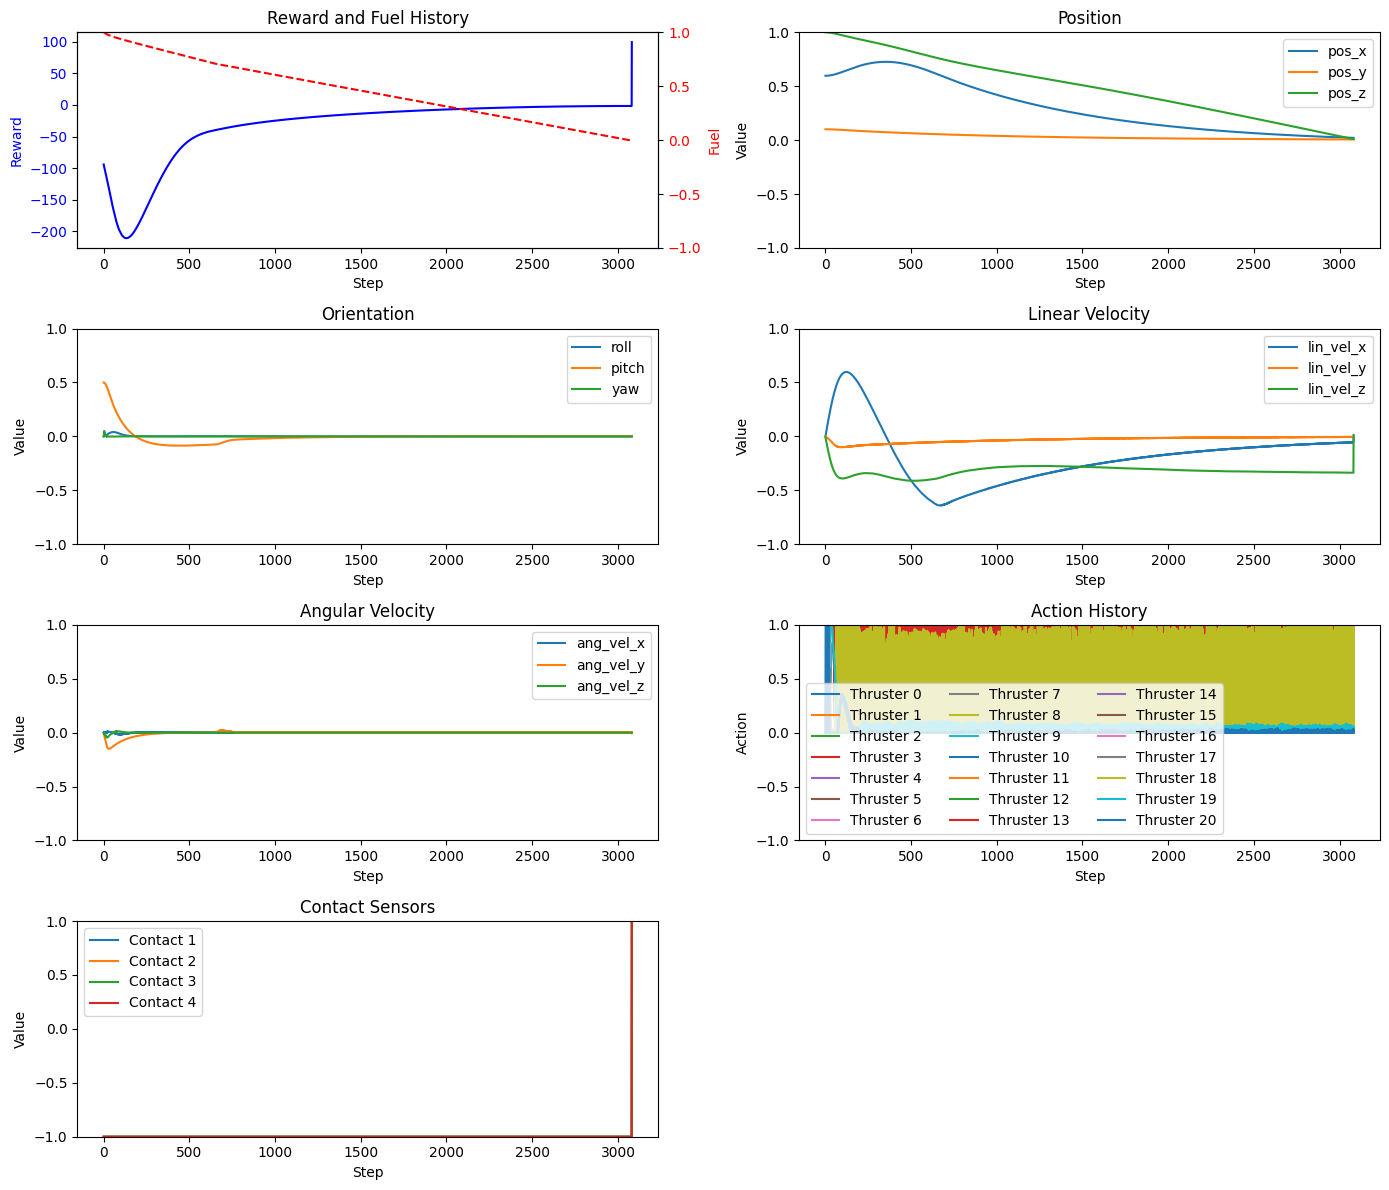

error: Not connected to physics server.

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import threading
########################################
# PID Controller Class
########################################



class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        p_term = self.kp * error
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        i_term = self.ki * self.integrator
        d_term = self.kd * ((error - self.prev_error) / self.dt)
        self.prev_error = error
        return p_term + i_term + d_term, p_term, i_term, d_term

########################################
# Combined Display (Tkinter GUI)
# Menampilkan PID parameters dan Observations & Actions
########################################


class CombinedDisplay(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Lunar Lander: PID, Observations & Actions")
        self.geometry("1200x600")
        
        # Buat frame utama untuk tiga kolom
        self.obs_frame = ttk.LabelFrame(self, text="Observations", padding=(10, 10))
        self.obs_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        
        self.act_frame = ttk.LabelFrame(self, text="Actions", padding=(10, 10))
        self.act_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        
        self.pid_frame = ttk.LabelFrame(self, text="PID Control", padding=(10, 10))
        self.pid_frame.grid(row=0, column=2, padx=10, pady=10, sticky="nsew")
        
        self._create_obs_widgets()
        self._create_act_widgets()
        self._create_pid_widgets()
        
        self.grid_columnconfigure(0, weight=1)
        self.grid_columnconfigure(1, weight=1)
        self.grid_columnconfigure(2, weight=2)
    
    def _create_obs_widgets(self):
        self.obs_labels = {}
        obs_names = ["pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
                     "lin_vel_x", "lin_vel_y", "lin_vel_z",
                     "ang_vel_x", "ang_vel_y", "ang_vel_z",
                     "fuel", "contact_1", "contact_2", "contact_3", "contact_4"]
        for i, name in enumerate(obs_names):
            ttk.Label(self.obs_frame, text=name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.obs_labels[name] = ttk.Label(self.obs_frame, text="0.0000", font=("Arial", 10))
            self.obs_labels[name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_act_widgets(self):
        self.action_labels = {}
        for i in range(21):
            action_name = f"Action {i}"
            ttk.Label(self.act_frame, text=action_name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.action_labels[action_name] = ttk.Label(self.act_frame, text="0.0000", font=("Arial", 10))
            self.action_labels[action_name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_pid_widgets(self):
        self.pid_labels = {}
        parameters = ["z", "roll", "pitch", "yaw"]
        components = ["PID Output", "Error", "Prev Error", "P", "I", "D"]
        
        for j, text in enumerate(["Parameter"] + components):
            ttk.Label(self.pid_frame, text=text, font=("Arial", 12)).grid(row=0, column=j, padx=5, pady=5)
        
        for i, param in enumerate(parameters):
            ttk.Label(self.pid_frame, text=param.upper(), font=("Arial", 12)).grid(row=i+1, column=0, padx=5, pady=5, sticky="w")
            for j, comp in enumerate(components):
                lbl = ttk.Label(self.pid_frame, text="0.0000", font=("Arial", 10))
                lbl.grid(row=i+1, column=j+1, padx=5, pady=5, sticky="w")
                self.pid_labels[f"{param}_{comp}"] = lbl
    
    def update_values(self, pid_data, obs, action):
        # Update Observations
        for key, val in zip(self.obs_labels.keys(), obs):
            self.obs_labels[key].config(text=f"{val:.4f}")
        
        # Update Actions
        for key, val in zip(self.action_labels.keys(), action):
            self.action_labels[key].config(text=f"{val:.4f}")
        
        # Update PID
        for key, value in pid_data.items():
            self.pid_labels[key].config(text=f"{value:.4f}")
        
        self.update()

    

########################################
# Lander PID Controller (21 Action Space)
########################################

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
    
        self.x_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.y_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.z_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)

        self.x_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.y_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.z_vel_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        
        self.pitch_pid = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
        self.roll_pid  = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
        self.yaw_pid   = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
    
    def denormalize(self, norm_obs):
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        # Ambil nilai observasi (nilai ternormalisasi)
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]      # Linear velocity
        
        # Hitung target z velocity secara interpolasi linear berdasarkan ketinggian
        target_vx = -pos[0]
        target_vy = -pos[1]
        target_vz = -pos[2] / 10.0

        x_vel_error = vel[0] - target_vx
        y_vel_error = vel[1] - target_vy
        z_vel_error = vel[2] - target_vz
        
        pitch_error = orient[1]  # target pitch = 0
        roll_error  = orient[0]  # target roll = 0
        yaw_error   = orient[2]  # target yaw = 0
        
        thrust_command, p_z, i_z, d_z = self.z_vel_pid.update(z_vel_error)
        lin_x_command, p_z, i_z, d_z = self.x_vel_pid.update(x_vel_error)
        lin_y_command, p_z, i_z, d_z = self.y_vel_pid.update(y_vel_error)

        pitch_correction, p_p, i_p, d_p = self.pitch_pid.update(pitch_error)
        roll_correction, p_r, i_r, d_r = self.roll_pid.update(roll_error)
        yaw_correction, p_y, i_y, d_y = self.yaw_pid.update(yaw_error)
        
        pid_data = {
                    "z_PID Output": thrust_command, "z_Error": z_vel_error, "z_P": p_z, "z_I": i_z, "z_D": d_z,
                    "pitch_PID Output": pitch_correction, "pitch_Error": pitch_error, "pitch_P": p_p, "pitch_I": i_p, "pitch_D": d_p,
                    "roll_PID Output": roll_correction, "roll_Error": roll_error, "roll_P": p_r, "roll_I": i_r, "roll_D": d_r,
                    "yaw_PID Output": yaw_correction, "yaw_Error": yaw_error, "yaw_P": p_y, "yaw_I": i_y, "yaw_D": d_y
                    }

        #Back -X | X Front
        #Right -Y | Y Left

        action = [
            #main
            -thrust_command,
            
            # Front
            #-x, +y, -y, +z, -z
            lin_x_command,       #good
            -yaw_correction,     #good
            yaw_correction,      #good
            pitch_correction,    #good
            -pitch_correction,   #good

            #Back
            #+x, +y, -y, +z, -z
            -lin_x_command,      #good
            yaw_correction,      #good
            -yaw_correction,     #good
            -pitch_correction,   #good
            pitch_correction,    #good

            #Left
            #+x, -x, -y, +z, -z
            yaw_correction,      #good
            -yaw_correction,     #good
            lin_y_command,       #good
            -roll_correction,    #good
            roll_correction,     #good

            #Right
            #+x, -x, +y, +z, -z
            -yaw_correction,     #good
            yaw_correction,      #good
            -lin_y_command,      #good
            roll_correction,     #good
            -roll_correction     #good
            
        ]

        #action =[  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        
        
        action_vector = np.clip(action, 0, 1)

        return action_vector, pid_data

########################################
# Program Utama: Inferensi, GUI, dan Plotting
########################################

def run_gui():
    gui.mainloop()

gui = CombinedDisplay()
gui_thread = threading.Thread(target=run_gui, daemon=True)
gui_thread.start()


if __name__ == '__main__':
    # Inisialisasi environment
    env = LunarLander3DEnv(render_mode='human')
    norm_obs, info = env.reset()
    env.render()
    dt = 1.0 / env.render_fps
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    
    # Data logging untuk plotting
    obs_history = []
    action_history = []
    reward_history = []
    fuel_history = []
    step_history = []
    prev_position = np.array(norm_obs[:3])  # Simpan posisi awal (x, y, z)
    update_distance = 0.5  # Jarak minimum untuk update GUI
    done = False
    while not done:
        action, pid_data = controller.compute_action(norm_obs)
        action_history.append(action.copy())
                
        norm_obs, reward, terminated, truncated, info = env.step(action)
        obs_history.append(norm_obs.copy())
        reward_history.append(reward)
        fuel_history.append(norm_obs[12])
        step_history.append(env.step_counter)
        done = terminated or truncated
        
        current_position = np.array(norm_obs[:3])  # Ambil posisi saat ini
        distance_moved = np.linalg.norm(current_position - prev_position)  # Hitung jarak berpindah
        
        # Perbarui GUI dengan PID, Observasi, dan Aksi
        gui.update_values(pid_data, norm_obs, action)
        env.render()
        if distance_moved >= update_distance:
              # Render ulang PyBullet
            prev_position = current_position  # Reset posisi sebelumnya
           
        # time.sleep(dt)
    
    env.close()
        # time.sleep(1/env.render_fps)  # Uncomment untuk real-time simulation
    
    # Konversi data ke numpy array
    obs_history = np.array(obs_history)
    action_history = np.array(action_history)
    reward_history = np.array(reward_history)
    fuel_history = np.array(fuel_history)
    step_history = np.array(step_history)
    
# Plotting
fig, axs = plt.subplots(4, 2, figsize=(14, 12))

# Plot 1: Reward dan Fuel
ax = axs[0, 0]
ax.plot(step_history, reward_history, 'b-', label='Reward')
ax.set_xlabel('Step')
ax.set_ylabel('Reward', color='b')
ax.tick_params(axis='y', labelcolor='b')

axb = ax.twinx()
axb.plot(step_history, fuel_history, 'r--', label='Fuel')
axb.set_ylabel('Fuel', color='r')
axb.tick_params(axis='y', labelcolor='r')
axb.set_ylim(-1, 1)  # Set limit y-axis
ax.set_title('Reward and Fuel History')

# Plot 2-7: State variables
plot_configs = [
    (0, 1, 'Position', ['pos_x', 'pos_y', 'pos_z'], 0, 3),
    (1, 0, 'Orientation', ['roll', 'pitch', 'yaw'], 3, 6),
    (1, 1, 'Linear Velocity', ['lin_vel_x', 'lin_vel_y', 'lin_vel_z'], 6, 9),
    (2, 0, 'Angular Velocity', ['ang_vel_x', 'ang_vel_y', 'ang_vel_z'], 9, 12),
    (3, 0, 'Contact Sensors', ['Contact 1', 'Contact 2', 'Contact 3', 'Contact 4'], 13, 17)
]

for row, col, title, labels, start_idx, end_idx in plot_configs:
    ax = axs[row, col]
    for i in range(end_idx - start_idx):
        ax.plot(step_history, obs_history[:, start_idx+i], label=labels[i])
    ax.set_xlabel('Step')
    ax.set_ylabel('Value')
    ax.set_ylim(-1, 1)  # Set limit y-axis

    ax.set_title(title)
    ax.legend()

# Plot 8: Action History
ax = axs[2, 1]
for i in range(action_history.shape[1]):
    ax.plot(step_history, action_history[:, i], label=f'Thruster {i}')
ax.set_xlabel('Step')
ax.set_ylabel('Action')
ax.set_ylim(-1, 1)  # Set limit y-axis
ax.set_title('Action History')
ax.legend(ncol=3)

axs[3, 1].axis('off')
plt.tight_layout()
plt.show()

env.close()


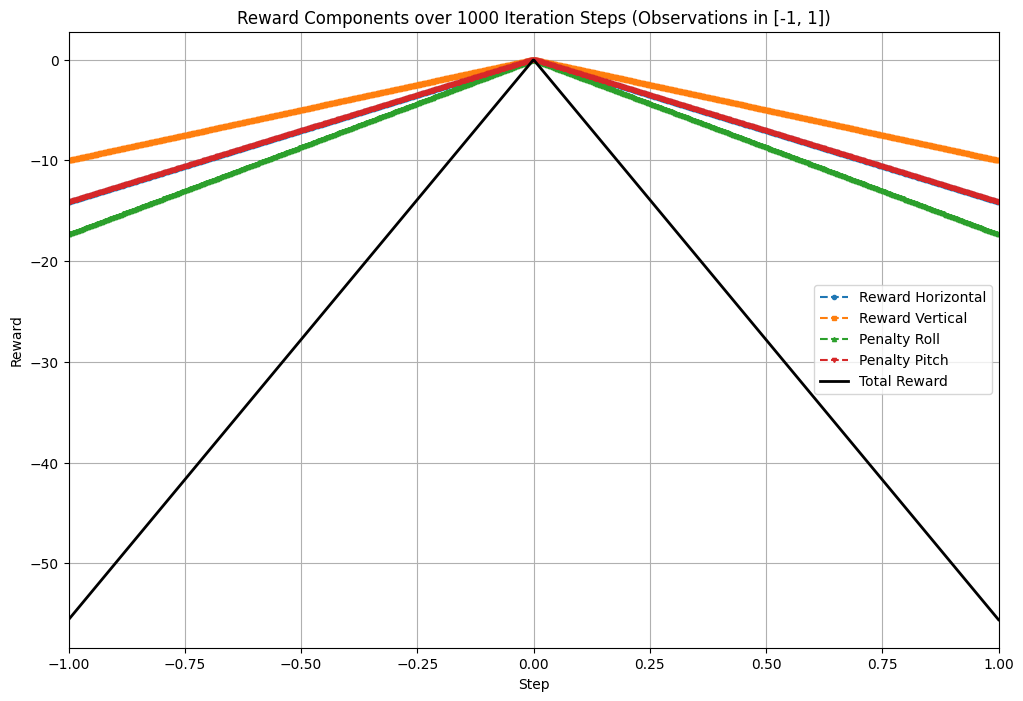

In [1]:
import numpy as np
import matplotlib.pyplot as plt

num_steps = 1000

# Buat vektor nilai secara deterministik menggunakan linspace dan fungsi trigonometri
x_vals = np.linspace(-1, 1, num_steps)               # pos_x: linear dari -1 ke 1
y_vals = np.linspace(-1, 1, num_steps)               # pos_y: linear dari 1 ke -1
z_vals = np.linspace(-1, 1, num_steps)               # pos_z: linear dari -1 ke 1

# Orientasi: roll, pitch, yaw (gunakan linspace atau sinus)
roll_vals = np.linspace(-1, 1, num_steps)            # roll: linear dari -1 ke 1
pitch_vals = np.linspace(-1, 1, num_steps)           # pitch: linear dari 1 ke -1
yaw_vals = np.linspace(-1, 1, num_steps)             # yaw: linear dari -1 ke 1

# Linear velocity: gunakan fungsi sinus untuk variasi yang smooth
t = np.linspace(0, 2*np.pi, num_steps)
lin_vel_x = np.linspace(-1, 1, num_steps) 
lin_vel_y = np.linspace(-1, 1, num_steps) 
lin_vel_z = np.linspace(-1, 1, num_steps) 

# Angular velocity: gunakan fungsi kosinus untuk variasi yang smooth
ang_vel_x = np.linspace(-1, 1, num_steps) 
ang_vel_y = np.linspace(-1, 1, num_steps) 
ang_vel_z = np.linspace(-1, 1, num_steps) 

# Fuel: linear dari 1 hingga -1
fuel_vals = np.linspace(1, -1, num_steps)

# Contact sensor: gunakan linspace sebagai contoh (nilai dari -1 ke 1)
contact1 = np.linspace(-1, 1, num_steps)
contact2 = np.linspace(1, -1, num_steps)
contact3 = np.linspace(-1, 1, num_steps)
contact4 = np.linspace(1, -1, num_steps)

# Simpan historis observasi dan reward
obs_history = []
reward_horizontal_list = []
reward_vertical_list = []
reward_roll_list = []
reward_pitch_list = []
total_reward_list = []

for i in range(num_steps):
    # Buat observasi sebagai vektor 17-dimensi secara iteratif
    pos = np.array([x_vals[i], y_vals[i], z_vals[i]])
    orient = np.array([roll_vals[i], pitch_vals[i], yaw_vals[i]])
    lin_vel = np.array([lin_vel_x[i], lin_vel_y[i], lin_vel_z[i]])
    ang_vel = np.array([ang_vel_x[i], ang_vel_y[i], ang_vel_z[i]])
    fuel = np.array([fuel_vals[i]])
    contact = np.array([contact1[i], contact2[i], contact3[i], contact4[i]])
    
    obs = np.concatenate([pos, orient, lin_vel, ang_vel, fuel, contact])
    obs_history.append(obs)
    
    # Hitung komponen reward
    # Reward horizontal: semakin dekat (x,y) ke 0, reward lebih tinggi
    reward_horizontal = - 10 * np.sqrt(pos[0]**2 + pos[1]**2)
    # Reward vertical: semakin dekat z ke 0, reward lebih tinggi
    reward_vertical = -10 * np.sqrt(pos[2]**2)
    # Penalti roll: semakin besar |roll|, penalti meningkat
    reward_roll = -10 * np.sqrt(orient[0]**2 + orient[1]**2 + orient[2]**2)
    
    # Penalti pitch: semakin besar |pitch|, penalti meningkat
    reward_pitch = -10 * np.sqrt(lin_vel[0]**2 + lin_vel[1]**2)
    
    total_reward = reward_horizontal + reward_vertical + reward_roll + reward_pitch
    
    reward_horizontal_list.append(reward_horizontal)
    reward_vertical_list.append(reward_vertical)
    reward_roll_list.append(reward_roll)
    reward_pitch_list.append(reward_pitch)
    total_reward_list.append(total_reward)

# Konversi observasi history ke array jika diperlukan
obs_history = np.array(obs_history)

# Plot grafik komponen reward
steps = np.linspace(-1, 1, num_steps)
plt.figure(figsize=(12, 8))
plt.plot(steps, reward_horizontal_list, label="Reward Horizontal", marker='o', markersize=3, linestyle='--')
plt.plot(steps, reward_vertical_list, label="Reward Vertical", marker='s', markersize=3, linestyle='--')
plt.plot(steps, reward_roll_list, label="Penalty Roll", marker='^', markersize=3, linestyle='--')
plt.plot(steps, reward_pitch_list, label="Penalty Pitch", marker='v', markersize=3, linestyle='--')
plt.plot(steps, total_reward_list, label="Total Reward", color="black", linewidth=2)
plt.xlim(-1, 1)
#plt.ylim(-1, 1)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Components over 1000 Iteration Steps (Observations in [-1, 1])")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
reward = 0.0
pos = [-1.0, 1.0, 1.0]

target_vx = -pos[0] / 20.0
target_vy = -pos[1] / 20.0
target_vz = -pos[2] / 10.0

print(f"{target_vx}, { target_vy}, {target_vz}")
lin_vel = [-0.0, 0.0, 0.]

reward1 = -100 * abs(lin_vel[0] - target_vx)**2
reward2 = -100 * abs(lin_vel[1] - target_vy)**2
reward3 = -100 * abs(lin_vel[2] - target_vz)**2

print(f"{reward1}, { reward2}, {reward3}")

reward += reward1+reward2+reward3
reward

0.005, -0.005, -0.1
-0.3025, -0.3025, -4.000000000000001


-4.605

In [8]:
import numpy as np
state = [3 , 4]
a = np.sqrt(state[0] * state[0] + state[1] * state[1])
#a = np.sqrt(9)
a

np.float64(5.0)